# 15. 트랜스포머로 만드는 대화형 챗봇

# 학습 목표
트랜스포머의 인코더 디코더 구조 이해하기  
내부 단어 토크나이저 사용하기  
셀프 어텐션 이해하기  
한국어에도 적용해보기  

# 목차
- 데이터 수집하기
- 데이터 전처리하기
- SubwordTextEncoder 사용하기
- 모델 구성하기
- 모델 평가하기

2. 손실 함수(Loss function)
레이블인 시퀀스에 패딩이 되어져 있으므로, loss를 계산할 때 패딩 마스크를 적용해야 합니다.

In [1]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)
print("슝=3")

슝=3


3. 커스텀된 학습률(Learning rate)
딥러닝 모델학습 시 learning rate는 매우 중요한 하이퍼파라미터입니다. 최근에는 모델학습 초기에 learning rate를 급격히 높였다가, 이후 train step이 진행됨에 따라 서서히 낮추어 가면서 안정적으로 수렴하게 하는 고급 기법을 널리 사용하고 있습니다. 이런 방법을 커스텀 학습률 스케줄링(Custom Learning rate Scheduling)이라고 합니다.

논문에 나온 공식을 참고하여 커스텀 학습률 스케줄러를 통한 아담 옵티마이저를 사용합니다. 논문에 나온 공식은 다음과 같습니다.

l
r
a
t
e
=
d
−
0.5
m
o
d
e
l
⋅
m
i
n
(
s
t
e
p
_
n
u
m
−
0.5
,
s
t
e
p
_
n
u
m
⋅
w
a
r
m
u
p
_
s
t
e
p
s
−
1.5
)

# 15. 프로젝트: 한국어 데이터로 챗봇 만들기
영어로 만들었던 챗봇을 한국어 데이터로 바꿔서 훈련시켜봅시다.

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1. 데이터 수집하기

- 한국어 챗봇 데이터는 송영숙님이 공개한 챗봇 데이터를 사용

- songys/Chatbot_data

In [3]:
!wget https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData%20.csv

--2021-03-11 09:43:54--  https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData%20.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
접속 raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... 접속됨.
HTTP request sent, awaiting response... 200 OK
Length: 889842 (869K) [text/plain]
Saving to: ‘ChatbotData .csv.6’

ChatbotData .csv.6  100%[===================>] 868.99K  1021KB/s    in 0.9s    

2021-03-11 09:43:55 (1021 KB/s) - ‘ChatbotData .csv.6’ saved [889842/889842]



In [4]:
#다운로드한 csv 파일 읽기
df = pd.read_csv('ChatbotData .csv')
df.sample(10)

,Q,A,label
9202,나만 좋아하는 건가 자괴감 들어.,상대방 마음을 좀 떠봐서 확인해보세요.,2
1098,늦잠과 브런치 수다가 있는 주말,완벽한 주말이네요.,0
10204,썸 타는 사이에 배낭여행 가능?,사귀고 가는 게 좋을 거 같아요.,2
9915,사랑이 뭐길래,사랑.... 정의 내리기 어려운 단어예요.,2
4011,재미없는 일밖에 없어,활기찬 사람을 만나보시면 생각이 바뀔 수도 있어요.,0
4975,학교 가기 싫다,학교 다닐 때가 좋은 거예요.,0
7531,이별을 실감하네,받아들이기 쉽지 않았을텐데 대단해요.,1
7502,이별에 답.,이별에 답이 있을까요.,1
6236,마지막입니다.,마지막을 잘 마무리 해야 시작도 잘 할 수 있을 거예요.,1
6403,미치겠습니다 하,제가 고민을 들어드릴게요.,1


# Step 2. 데이터 전처리하기

영어 데이터와는 전혀 다른 데이터인 만큼 영어 데이터에 사용했던 전처리와 일부 동일한 전처리도 필요하겠지만 전체적으로는 다른 전처리를 수행해야 할 수도 있습니다.

In [5]:
# 전처리 함수
def preprocess_sentence(sentence):
  sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  # (a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
  
  #영어 정규표현식  
  #sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
  #한글 정규표현식
  sentence = re.sub(r"[^ㄱ-ㅣ가-힣a-zA-Z0-9?.!,]+", " ", sentence)
  sentence = sentence.strip()
  return sentence
print("슝=3")

슝=3


In [6]:
#한글 전처리 확인
test_sentence = '잘 되어 가고 있니? 123@#%%^'
preprocess_sentence(test_sentence)

'잘 되어 가고 있니 ? 123'

In [7]:
#Q값 questions로
questions = df.Q.values
questions, len(questions)
#11823개

(array(['12시 땡!', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', ..., '흑기사 해주는 짝남.',
        '힘든 연애 좋은 연애라는게 무슨 차이일까?', '힘들어서 결혼할까봐'], dtype=object),
 11823)

In [8]:
#A값 answers로
answers = df.A.values
answers, len(answers)
#11823개

(array(['하루가 또 가네요.', '위로해 드립니다.', '여행은 언제나 좋죠.', ..., '설렜겠어요.',
        '잘 헤어질 수 있는 사이 여부인 거 같아요.', '도피성 결혼은 하지 않길 바라요.'], dtype=object),
 11823)

In [9]:
questions[:5], answers[:5]

(array(['12시 땡!', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다',
        'PPL 심하네'], dtype=object),
 array(['하루가 또 가네요.', '위로해 드립니다.', '여행은 언제나 좋죠.', '여행은 언제나 좋죠.',
        '눈살이 찌푸려지죠.'], dtype=object))

In [10]:
#questions와 answers 한글 전처리하기
questions = list(map(preprocess_sentence, questions))
answers = list(map(preprocess_sentence, answers))

In [11]:
#전처리 확인
questions[:5], answers[:5]

(['12시 땡 !', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다', 'ppl 심하네'],
 ['하루가 또 가네요 .', '위로해 드립니다 .', '여행은 언제나 좋죠 .', '여행은 언제나 좋죠 .', '눈살이 찌푸려지죠 .'])

# Step 3. SubwordTextEncoder 사용하기

- ```TensorFlow Datasets```의 ```SubwordTextEncoder```를 활용해서 토큰화
- ```tokenize_and_filter```함수
    - 문장을 정수로 인코딩 수행
    - 설정한 최대 길이를 넘어갈 경우 샘플을 제거
    - 최대 길이보다 짧을 경우, 패딩 수행

In [12]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)
print("슝=3 ")

슝=3 


In [13]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print("슝=3")

슝=3


In [14]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8170]
END_TOKEN의 번호 : [8171]


In [15]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8172


In [16]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40
print(MAX_LENGTH)

40


In [17]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
    
    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        # 최대 길이 40이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)

    # 최대 길이 40으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

    return tokenized_inputs, tokenized_outputs

정수 인코딩 과정을 수행하면서 샘플의 길이가 40을 넘는 경우는 샘플들을 필터링하였으므로 일부 샘플이 제외되었습니다.  
단어장의 크기와 샘플의 개수를 확인해 보겠습니다.

In [18]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8172
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


# Step 4. 모델 구성하기

---
- ```teacher forcing```사용
    - ```answer[:,:-1]```를 디코더의 입력값, ```answer[:,1:]```를 디코더의 레이블로 사용한다
- ```tf.data.Dataset``` API활용, 파이프라인 구축

위 실습 내용을 참고하여 트랜스포머 모델을 구현합니다.

In [19]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
print("슝=3")
슝=3

슝=3


In [20]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

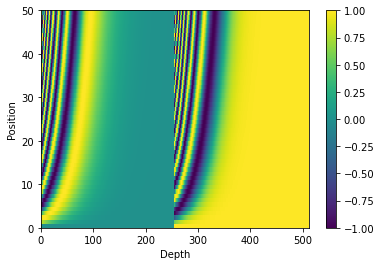

In [21]:
sample_pos_encoding = PositionalEncoding(50, 512)

#plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0])
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [22]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    
    """어텐션 가중치를 계산. """
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # scale matmul_qk
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # add the mask to zero out padding tokens
    if mask is not None:
        logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k)
    attention_weights = tf.nn.softmax(logits, axis=-1)

    output = tf.matmul(attention_weights, value)

    return output

In [23]:
#MultiHeadAttention
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # linear layers
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다.
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷-프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다.
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # final linear layer
        outputs = self.dense(concat_attention)

        return outputs

In [24]:
#패팅 마스킹
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [25]:
#Look-ahead 마스킹
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

# 인코더

In [26]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
          })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(inputs + attention)

    # 두번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [27]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)


# 디코더

In [28]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': look_ahead_mask
        })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention1 + inputs)

    # 두번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
            'query': attention1,
            'key': enc_outputs,
            'value': enc_outputs,
            'mask': padding_mask
        })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention2 + attention1)

    # 세번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

In [29]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

# 트랜스포머

In [30]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)

    # 디코더에서 미래의 토큰을 마스크하기위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

    # 두번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

    # 인코더
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

      # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
      )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [31]:
tf.keras.backend.clear_session()

# 이전 하이퍼파라미터 
# NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
# D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
# NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
# UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
# DROPOUT = 0.1 # 드롭아웃의 비율

# 이후 하이퍼파라미터
NUM_LAYERS = 6 # 인코더와 디코더의 층의 개수
D_MODEL = 512 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Model)                 (None, None, 512)    13651968    inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [32]:
# 손실함수
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

In [33]:
# 커스텀 학습률
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


# Step 5. 모델 평가하기

Step 1에서 선택한 전처리 방법을 고려하여 입력된 문장에 대해서 대답을 얻는 예측 함수를 만듭니다.

In [35]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞 뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없으므로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [36]:
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))

    return predicted_sentence

In [37]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [38]:
EPOCHS = 20
history = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
185/185 [==============================] - 38s 207ms/step - loss: 1.3495 - accuracy: 0.0228
Epoch 2/20
185/185 [==============================] - 39s 209ms/step - loss: 1.0766 - accuracy: 0.0488
Epoch 3/20
185/185 [==============================] - 40s 214ms/step - loss: 0.9812 - accuracy: 0.0509
Epoch 4/20
185/185 [==============================] - 39s 212ms/step - loss: 0.9362 - accuracy: 0.0531
Epoch 5/20
185/185 [==============================] - 40s 214ms/step - loss: 0.8991 - accuracy: 0.0554
Epoch 6/20
185/185 [==============================] - 39s 212ms/step - loss: 0.8598 - accuracy: 0.0576
Epoch 7/20
185/185 [==============================] - 39s 213ms/step - loss: 0.8159 - accuracy: 0.0602
Epoch 8/20
185/185 [==============================] - 40s 214ms/step - loss: 0.7664 - accuracy: 0.0633
Epoch 9/20
185/185 [==============================] - 39s 213ms/step - loss: 0.7093 - accuracy: 0.0679
Epoch 10/20
185/185 [==============================] - 39s 213ms/step - l

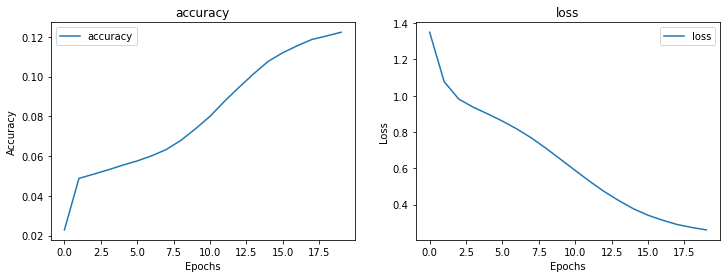

In [39]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.title('accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'])
plt.legend(['accuracy'], loc='best')

plt.subplot(122)
plt.title('loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(history.history['loss'])
plt.legend(['loss'], loc='best')
plt.show()

In [40]:
sentence_generation('아 졸려')

입력 : 아 졸려
출력 : 저도 사는데요 .


'저도 사는데요 .'

In [41]:
sentence_generation("추워")

입력 : 추워
출력 : 오늘 강추위래요 .


'오늘 강추위래요 .'

In [42]:
sentence_generation("피곤해")

입력 : 피곤해
출력 : 좋은 생각이에요 .


'좋은 생각이에요 .'

In [43]:
sentence_generation("잘하고 있는 건지 모르겠어")

입력 : 잘하고 있는 건지 모르겠어
출력 : 좋은 사람 만나보세요 .


'좋은 사람 만나보세요 .'

# EPOCH 변경

In [44]:
EPOCHS = 50
history = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/50
185/185 [==============================] - 40s 218ms/step - loss: 0.2514 - accuracy: 0.1238
Epoch 2/50
185/185 [==============================] - 40s 218ms/step - loss: 0.2435 - accuracy: 0.1248
Epoch 3/50
185/185 [==============================] - 41s 220ms/step - loss: 0.2294 - accuracy: 0.1272
Epoch 4/50
185/185 [==============================] - 41s 219ms/step - loss: 0.2149 - accuracy: 0.1293
Epoch 5/50
185/185 [==============================] - 40s 215ms/step - loss: 0.2036 - accuracy: 0.1312
Epoch 6/50
185/185 [==============================] - 40s 218ms/step - loss: 0.1909 - accuracy: 0.1331
Epoch 7/50
185/185 [==============================] - 40s 215ms/step - loss: 0.1793 - accuracy: 0.1353
Epoch 8/50
185/185 [==============================] - 40s 218ms/step - loss: 0.1714 - accuracy: 0.1365
Epoch 9/50
185/185 [==============================] - 40s 215ms/step - loss: 0.1627 - accuracy: 0.1377
Epoch 10/50
185/185 [==============================] - 40s 216ms/step - l

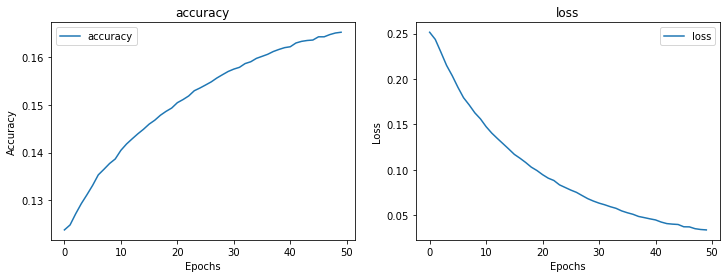

In [45]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.title('accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'])
plt.legend(['accuracy'], loc='best')

plt.subplot(122)
plt.title('loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(history.history['loss'])
plt.legend(['loss'], loc='best')
plt.show()

In [46]:
sentence_generation('아 졸려')

입력 : 아 졸려
출력 : 오늘 일찍 주무세요 .


'오늘 일찍 주무세요 .'

In [47]:
sentence_generation("추워")

입력 : 추워
출력 : 따듯한 차 한잔 어때요 ?


'따듯한 차 한잔 어때요 ?'

In [48]:
sentence_generation("피곤해")

입력 : 피곤해
출력 : 푹 쉬세요 .


'푹 쉬세요 .'

In [49]:
sentence_generation("잘하고 있는 건지 모르겠어")

입력 : 잘하고 있는 건지 모르겠어
출력 : 잘하고 있을 거예요 .


'잘하고 있을 거예요 .'

---
# 루브릭

아래의 기준을 바탕으로 프로젝트를 평가합니다.

평가문항/상세기준
1. 한국어 전처리를 통해 학습 데이터셋을 구축하였다.  
공백과 특수문자 처리, 토크나이징, 병렬데이터 구축의 과정이 적절히 진행되었다.  


2. 트랜스포머 모델을 구현하여 한국어 챗봇 모델 학습을 정상적으로 진행하였다.  
구현한 트랜스포머 모델이 한국어 병렬 데이터 학습 시 안정적으로 수렴하였다.  


3. 한국어 입력문장에 대해 한국어로 답변하는 함수를 구현하였다.  
한국어 입력문장에 그럴듯한 한국어로 답변을 리턴하였다.  


# 결과 & 고찰

다른 분들의 학습 결과에서 제대로된 결과를 얻을 수 있는지에 대한 의문으로 시작하였습니다.  
한국어 전처리와 영어의 전처리와의 차이를 보았다.
epoch을 20회에서 50회로 늘려서 학습에 변화를 주었을 때, accuracy와 loss의 결과가 더욱 좋아져서 sentence_generation의 결과도 훨씬 좋아지는 것을 알 수 있었다. 

Q1
sentence_generation('아 졸려')
epoch 20 : 저도 사는데요 .
epoch 50 : 출력 : 오늘 일찍 주무세요 .

Q2
sentence_generation("추워")
epoch 20 : 오늘 강추위래요 .
epoch 50 : 따듯한 차 한잔 어때요 ?

Q3
sentence_generation("피곤해")
epoch 20 : 좋은 생각이에요 .
epoch 50 : 푹 쉬세요 .

Q4
sentence_generation("잘하고 있는 건지 모르겠어")
epoch 20 : 좋은 사람 만나보세요 .
epoch 50 : 잘하고 있을 거예요 .
